<a href="https://colab.research.google.com/github/DHKing7/Final_Project/blob/main/DH_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Google Drive Mount

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive/MyDrive

/content/drive/MyDrive


# CUDA 삭제 후 버전 맞춤

In [ ]:
!nvcc --version

/bin/bash: nvcc: command not found


In [ ]:
!apt-get --purge remove cuda nvidia* libnvidia-*
!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
!apt-get remove cuda-*
!apt autoremove
!apt-get update

In [ ]:
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-ubuntu1804.pin
!sudo mv cuda-ubuntu1804.pin /etc/apt/preferences.d/cuda-repository-pin-600
!sudo apt-key adv --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/7fa2af80.pub
!sudo add-apt-repository "deb https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/ /"
!apt-get update
!apt-get -y install cuda-11.6

In [ ]:
!pip uninstall torch torchvision
!pip install torch==1.7.1 torchvision==0.8.2 torchaudio==0.7.2

In [ ]:
import torch
print("Torch version:{}".format(torch.__version__))
print("cuda version: {}".format(torch.version.cuda))
print("cudnn version:{}".format(torch.backends.cudnn.version()))

Torch version:1.7.1
cuda version: 10.2
cudnn version:7605


In [ ]:
%cd drive/MyDrive

/content/drive/MyDrive


In [ ]:
!nvidia-smi

Wed Mar 29 12:52:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    25W /  70W |   3845MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Wed_Oct_23_19:24:38_PDT_2019
Cuda compilation tools, release 10.2, V10.2.89


# Dataset

In [3]:
import json
import os
from torch.utils.data import Dataset
import numpy as np
import cv2

In [4]:
class SDLane(Dataset):
  def __init__(self, path, image_set, transforms = None):
    super(SDLane, self).__init__()
    assert image_set in ('train', 'val', 'test'), "image_set is not valid!" # 'val'은 없음
    self.data_dir_path = path # SDLane/
    self.image_set = image_set # train/ or test/
    self.transforms = transforms
    

    if not os.path.exists(os.path.join(path, image_set, "seg_labels")): # SDLane/train/seg_label
      print("Label is going to get generated into dir: {} ...".format(os.path.join(path, "seg_labels")))
      self.generate_label()
    self.createIndex()



  def createIndex(self):
    self.img_list = [] # img 파일명
    self.segLabel_list = [] # ["Geometry"] 정 json 열고 세그멘테이션 이미지 변환한거


    listfile = os.path.join(self.data_dir_path,self.image_set, "{}_list.txt".format(self.image_set)) # txt파일에 images/0932b1d66d21e2ce4de81086645ebd93955fb0c1/0001.jpg 형식으로 39000개 존재
    if not os.path.exists(listfile):
      raise FileNotFoundError("List file doesn't exist. Label has to be generated!")
    
    with open(listfile) as f: ### 리스트 파일 열어서 한줄 씩 lable,img 리스트에 추가
      for line in f:
        line = line.strip()
        l = line.split("/") #["images", "0932b1d66d21e2ce4de81086645ebd93955fb0c1", "0001.jpg"]

        json_path = os.path.join(self.data_dir_path, self.image_set,"labels", l[1], l[2][:-4]+".json") # SDLane/train/seg_labels/0932b1d66d21e2ce4de81086645ebd93955fb0c1/0001.json
        with open(json_path, "r") as f: # json_path 수정
          annotation = json.load(f)


        self.img_list.append(os.path.join(self.data_dir_path, self.image_set, line)) # SDLane/train/images/0932b1d66d21e2ce4de81086645ebd93955fb0c1/0001.jpg
        self.segLabel_list.append(os.path.join(self.data_dir_path, self.image_set,"seg_labels", l[1], l[2])) # SDLane/train/seg_labels/0932b1d66d21e2ce4de81086645ebd93955fb0c1/0001.jpg


  
  def __getitem__(self, idx):
    img = cv2.imread(self.img_list[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.image_set != "test":
      segLabel = cv2.imread(self.segLabel_list[idx])[:,:,1]/255.0
    else:
      segLabel = None

    sample = {"img": img,
              "segLabel": segLabel,
              "img_name": self.img_list[idx]}
    
    if self.transforms is not None:
      sample = self.transforms(sample)
    return sample

  def __len__(self):
    return len(self.img_list)

  def generate_label(self):
    save_dir = os.path.join(self.data_dir_path, self.image_set, "seg_labels") #SDLane/train/seg_labels/
    os.makedirs(save_dir, exist_ok = True)


    self._gen_label_for_json(self.image_set, vis = None)



  def _gen_label_for_json(self, image_set, vis = None):
    H, W = 1208, 1920

    save_dir = "seg_labels"

    listf = os.path.join(self.data_dir_path, self.image_set, "{}_list.txt".format(image_set))
    if not os.path.exists(listf):
      raise FileNotFoundError("List file doesn't exist. Label has to be generated!")

    with open(listf) as f: ### 리스트 파일 열어서 한줄 씩 lable,img 리스트에 추가
      for line in f:
        line = line.strip()
        l = line.split("/") #["images", "0932b1d66d21e2ce4de81086645ebd93955fb0c1", "0001.jpg"]

        json_path = os.path.join(self.data_dir_path, self.image_set,"labels", l[1], l[2][:-4]+".json") #SDLane/train/labels/0932b1d66d21e2ce4de81086645ebd93955fb0c1/0001.json
        
        seg = os.path.join(self.data_dir_path, self.image_set,"seg_labels",l[1]) #SDLane/train/seg_labels/0932b1d66d21e2ce4de81086645ebd93955fb0c1/
        os.makedirs(seg, exist_ok=True)


    ### json 파일 불러오기 key = "geometry", "idx"
        with open(json_path, "r") as f: # json_path 수정
          annotation = json.load(f)

        if vis is None:
          vis = np.zeros((H,W,3), dtype = np.uint8)
          vis = np.ascontiguousarray(vis)


        lane_geometry = annotation["geometry"]

        pts = [np.int32(lane) for lane in lane_geometry if not len(lane) == 0]
        vis = cv2.polylines(vis, pts, False, (0, 255, 0), 10) # vis -> seg_label로 이동시켜야함
        seg_path = os.path.join(seg, l[2]) #SDLane/train/seg_labels/0932b1d66d21e2ce4de81086645ebd93955fb0c1/0001.jpg
        cv2.imwrite(seg_path, vis) #
        vis = None

  @staticmethod 
  def collate(batch):
    if isinstance(batch[0]['img'], torch.Tensor):
      img = torch.stack([b['img'] for b in batch])
    else:
      img = [b['img'] for b in batch]

    if batch[0]['segLabel'] is None:
      segLabel = None

    elif isinstance(batch[0]['segLabel'], torch.Tensor):
      segLabel = torch.stack([b['segLabel'] for b in batch])
           
    else:
      segLabel = [b['segLabel'] for b in batch]

    samples = {'img': img,
              'segLabel': segLabel,
              'img_name': [x['img_name'] for x in batch]}

    return samples

# 모델 완성

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.onnx

In [6]:
class DH_net(nn.Module):
  def __init__(self, pretrained = True):  #[lane]
    super(DH_net, self).__init__()
    self.pretrained = pretrained
    self.net_init()
    self.ce_loss = nn.CrossEntropyLoss()


  def forward(self, img, seg_gt = None):
    feature_map = self.backbone(img)
   

    feature1 = self.layer1(feature_map) # (nB, 128, 36, 100)    output_stride = 8

    feature2 = self.layer2(feature_map) # (nB, 128, 36, 100)
    feature3 = self.layer3(feature_map) # (nB, 128, 36, 100)
    feature4 = self.layer4(feature_map) # (nB, 128, 36, 100)

    feature5 = self.layer5(feature_map) # (nB, 128, 1, 1)
    feature5 = F.upsample(feature5, size = (36, 100), mode = "bilinear") # (nB, 128, 36, 100)

    out = torch.cat([feature1, feature2, feature3, feature4, feature5], 1) 

    out = self.layer6(out) # (nB, 2, 36, 100) [lane]

    seg_pred = F.interpolate(out, scale_factor=8, mode='bilinear', align_corners=True)

    if seg_gt is not None:
      loss = self.ce_loss(seg_pred, seg_gt)
    else:
      loss = torch.tensor(0, dtype=img.dtype, device=img.device)
    
    return seg_pred, loss




  def net_init(self):
    self.backbone = models.vgg16_bn(pretrained= self.pretrained).features

      # ----------------- process backbone -----------------
    for i in [34, 37, 40]:
      conv = self.backbone._modules[str(i)]
      dilated_conv = nn.Conv2d(
          conv.in_channels, conv.out_channels, conv.kernel_size, stride=conv.stride,
          padding=tuple(p * 2 for p in conv.padding), dilation=2, bias=(conv.bias is not None)
          )
      dilated_conv.load_state_dict(conv.state_dict())
      self.backbone._modules[str(i)] = dilated_conv
    self.backbone._modules.pop('33')
    self.backbone._modules.pop('43')
    # 512, 36, 100
    self.layer1 = nn.Sequential(
        nn.Conv2d(512, 128, 1, bias=False), 
        nn.BatchNorm2d(128),
        nn.ReLU()  # (nB, 128, 36, 100)    output_stride = 8
        )
    
    # rate = 6
    self.layer2 = nn.Sequential(
        nn.Conv2d(512, 128, 3, padding = 6, dilation = 6, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU() # (nB, 128, 36, 100)
    )
    # rate = 12
    self.layer3 = nn.Sequential(
        nn.Conv2d(512, 128, 3, padding = 12, dilation = 12, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU() # (nB, 128, 36, 100)
    )

    # rate 18
    self.layer4 = nn.Sequential(
        nn.Conv2d(512, 128, 3, padding = 18, dilation = 18, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU() # (nB, 128, 36, 100)
    )

    self.layer5 = nn.Sequential(
        nn.AdaptiveAvgPool2d(1), # (nB, 512, 1, 1)
        nn.Conv2d(512, 128, 1, bias = False), # (nB, 128, 1, 1)
        nn.BatchNorm2d(128),
        nn.ReLU()
    )

    self.layer6 = nn.Sequential(
        nn.Conv2d(640, 128, 1, bias = False), # (nB, 128*5, 36, 100)
        nn.BatchNorm2d(128),
        nn.ReLU(), # (nB, 128, 36, 100)
        nn.Conv2d(128, 2, 1, bias = False) # nn (nB, 2, 36, 100) [lane]
    )

# 데이터로더

In [7]:
import shutil
import time

import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm


from utils.transforms import *
from utils.tensorboard import TensorBoard
from utils.lr_scheduler import PolyLR

In [8]:
exp_dir = "experiments/exp0"
exp_name = "exp0"

with open(os.path.join(exp_dir, "cfg.json")) as f:
    exp_cfg = json.load(f)
resize_shape = tuple(exp_cfg['dataset']['resize_shape'])

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
tensorboard = TensorBoard(exp_dir)

In [9]:
mean=(0.485, 0.456, 0.406)
std=(0.229, 0.224, 0.225)
transform_train = Compose(Resize(resize_shape), Rotation(2), ToTensor(),
                          Normalize(mean=mean, std=std))

train_dataset = SDLane("SDLane2", "train", transforms = transform_train)
train_loader = DataLoader(train_dataset, batch_size = 4, shuffle=True, collate_fn = train_dataset.collate, num_workers=0)

In [10]:
transform_val = Compose(Resize(resize_shape),ToTensor(), 
                        Normalize(mean=mean, std=std))

val_dataset = SDLane("SDLane2", "val", transforms = transform_val)
val_loader = DataLoader(val_dataset, batch_size=1, collate_fn=val_dataset.collate, num_workers=0)

In [11]:
net = DH_net(pretrained=True)
net = net.to(device)

optimizer = optim.SGD(net.parameters(),**exp_cfg['optim'])
lr_scheduler = PolyLR(optimizer, 0.9, **exp_cfg['lr_scheduler'])
best_val_loss = 1e6

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

# 학습

In [12]:
def train(epoch):
    print("Train Epoch: {}".format(epoch))
    net.train()
    train_loss = 0
    progressbar = tqdm(range(len(train_loader)))

    for batch_idx, sample in enumerate(train_loader):
        img = sample['img'].to(device)
        segLabel = sample['segLabel'].to(device)

        optimizer.zero_grad()
        seg_pred, loss = net(img, segLabel)
        if isinstance(net, torch.nn.DataParallel):
            loss = loss.sum()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        iter_idx = epoch * len(train_loader) + batch_idx
        train_loss = loss.item()

        progressbar.set_description("batch loss: {:.3f}".format(loss.item()))
        progressbar.update(1)

        lr = optimizer.param_groups[0]['lr']
        tensorboard.scalar_summary(exp_name + "/train_loss", train_loss, iter_idx)
        tensorboard.scalar_summary(exp_name + "/learning_rate", lr, iter_idx)

    progressbar.close()
    tensorboard.writer.flush()

    if epoch % 1 == 0:
        save_dict = {
            "epoch": epoch,
            "net": net.module.state_dict() if isinstance(net, torch.nn.DataParallel) else net.state_dict(),
            "optim": optimizer.state_dict(),
            "lr_scheduler": lr_scheduler.state_dict(),
            "best_val_loss": best_val_loss
        }
        save_name = os.path.join(exp_dir, exp_name + '.pt')
        torch.save(save_dict, save_name)
        print("model is saved: {}".format(save_name))

    print("------------------------\n")

In [13]:
def val(epoch):
    global best_val_loss

    print("Val Epoch: {}".format(epoch))

    net.eval()
    val_loss = 0

    progressbar = tqdm(range(len(val_loader)))

    with torch.no_grad():
        for batch_idx, sample in enumerate(val_loader):
            img = sample['img'].to(device)
            segLabel = sample['segLabel'].to(device)
            seg_pred, loss = net(img, segLabel)
            if isinstance(net, torch.nn.DataParallel):
                loss = loss.sum()

            val_loss += loss.item()


            progressbar.set_description("batch loss: {:.3f}".format(loss.item()))
            progressbar.update(1)

    progressbar.close()
    iter_idx = (epoch + 1) * len(train_loader)  # keep align with training process iter_idx
    tensorboard.scalar_summary("val_loss", val_loss, iter_idx)
    tensorboard.writer.flush()

    print("------------------------\n")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_name = os.path.join(exp_dir, exp_name + '.pt')
        copy_name = os.path.join(exp_dir, exp_name + '_best.pt')
        shutil.copyfile(save_name, copy_name)

In [14]:
def main():
  global best_val_loss
  start_epoch = 0
  for epoch in range(start_epoch, 20):
    train(epoch)
    if epoch % 5 == 0:
      print("\nValidation For Experiment: ", exp_dir)
      print(time.strftime('%H:%M:%S', time.localtime()))
      val(epoch)

In [15]:
main()

Train Epoch: 0


  0%|          | 0/428 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
batch loss: 0.019: 100%|██████████| 428/428 [17:36<00:00,  2.47s/it]


model is saved: experiments/exp0/exp0.pt
------------------------


Validation For Experiment:  experiments/exp0
13:16:08
Val Epoch: 0


batch loss: 0.021: 100%|██████████| 51/51 [00:43<00:00,  1.17it/s]


------------------------

Train Epoch: 1


batch loss: 0.019: 100%|██████████| 428/428 [02:08<00:00,  3.32it/s]


model is saved: experiments/exp0/exp0.pt
------------------------

Train Epoch: 2


batch loss: 0.017: 100%|██████████| 428/428 [02:09<00:00,  3.31it/s]


model is saved: experiments/exp0/exp0.pt
------------------------

Train Epoch: 3


batch loss: 0.017: 100%|██████████| 428/428 [02:09<00:00,  3.31it/s]


model is saved: experiments/exp0/exp0.pt
------------------------

Train Epoch: 4


batch loss: 0.017: 100%|██████████| 428/428 [02:09<00:00,  3.30it/s]


model is saved: experiments/exp0/exp0.pt
------------------------

Train Epoch: 5


batch loss: 0.018: 100%|██████████| 428/428 [02:09<00:00,  3.31it/s]


model is saved: experiments/exp0/exp0.pt
------------------------


Validation For Experiment:  experiments/exp0
13:27:41
Val Epoch: 5


batch loss: 0.020: 100%|██████████| 51/51 [00:03<00:00, 15.43it/s]


------------------------

Train Epoch: 6


batch loss: 0.017: 100%|██████████| 428/428 [02:09<00:00,  3.30it/s]


model is saved: experiments/exp0/exp0.pt
------------------------

Train Epoch: 7


batch loss: 0.011: 100%|██████████| 428/428 [02:10<00:00,  3.29it/s]


model is saved: experiments/exp0/exp0.pt
------------------------

Train Epoch: 8


batch loss: 0.017: 100%|██████████| 428/428 [02:10<00:00,  3.29it/s]


model is saved: experiments/exp0/exp0.pt
------------------------

Train Epoch: 9


batch loss: 0.017: 100%|██████████| 428/428 [02:10<00:00,  3.28it/s]


model is saved: experiments/exp0/exp0.pt
------------------------

Train Epoch: 10


batch loss: 0.020: 100%|██████████| 428/428 [02:10<00:00,  3.29it/s]


model is saved: experiments/exp0/exp0.pt
------------------------


Validation For Experiment:  experiments/exp0
13:38:37
Val Epoch: 10


batch loss: 0.018: 100%|██████████| 51/51 [00:03<00:00, 15.30it/s]


------------------------

Train Epoch: 11


batch loss: 0.017: 100%|██████████| 428/428 [02:10<00:00,  3.29it/s]


model is saved: experiments/exp0/exp0.pt
------------------------

Train Epoch: 12


batch loss: 0.017: 100%|██████████| 428/428 [02:10<00:00,  3.28it/s]


model is saved: experiments/exp0/exp0.pt
------------------------

Train Epoch: 13


batch loss: 0.012: 100%|██████████| 428/428 [02:10<00:00,  3.28it/s]


model is saved: experiments/exp0/exp0.pt
------------------------

Train Epoch: 14


batch loss: 0.023: 100%|██████████| 428/428 [02:09<00:00,  3.30it/s]


model is saved: experiments/exp0/exp0.pt
------------------------

Train Epoch: 15


batch loss: 0.020: 100%|██████████| 428/428 [02:09<00:00,  3.30it/s]


model is saved: experiments/exp0/exp0.pt
------------------------


Validation For Experiment:  experiments/exp0
13:49:32
Val Epoch: 15


batch loss: 0.020: 100%|██████████| 51/51 [00:03<00:00, 15.47it/s]


------------------------

Train Epoch: 16


batch loss: 0.019: 100%|██████████| 428/428 [02:09<00:00,  3.31it/s]


model is saved: experiments/exp0/exp0.pt
------------------------

Train Epoch: 17


batch loss: 0.017: 100%|██████████| 428/428 [02:09<00:00,  3.30it/s]


model is saved: experiments/exp0/exp0.pt
------------------------

Train Epoch: 18


batch loss: 0.017: 100%|██████████| 428/428 [02:09<00:00,  3.31it/s]


model is saved: experiments/exp0/exp0.pt
------------------------

Train Epoch: 19


batch loss: 0.021: 100%|██████████| 428/428 [02:09<00:00,  3.30it/s]


model is saved: experiments/exp0/exp0.pt
------------------------



In [16]:
net.eval()
with torch.no_grad():
  for batch_idx, sample in enumerate(val_loader):
    img = sample['img'].to(device)
    segLabel = sample['segLabel'].to(device)
    seg_pred, loss = net(img, segLabel)
    break

img = img.detach().cpu()
pred = seg_pred.detach().cpu()

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [17]:
print(img)

tensor([[[[ 0.3138,  0.3138,  0.3138,  ...,  0.2796,  0.2796,  0.2796],
          [ 0.3138,  0.3138,  0.3138,  ...,  0.0569,  0.0569,  0.0569],
          [ 0.0056,  0.1254,  0.2453,  ..., -0.0287, -0.0287, -0.0287],
          ...,
          [ 1.4440,  1.4440,  1.4440,  ...,  1.5639,  1.5639,  1.5639],
          [ 1.5297,  1.5297,  1.5297,  ...,  1.6495,  1.6495,  1.6495],
          [ 1.5297,  1.5297,  1.5297,  ...,  1.6495,  1.6495,  1.6495]],

         [[ 1.2206,  1.2206,  1.2206,  ...,  0.8529,  0.8529,  0.8529],
          [ 1.2206,  1.2206,  1.2206,  ...,  0.6254,  0.6254,  0.6254],
          [ 0.9055,  1.0280,  1.1506,  ...,  0.5378,  0.5378,  0.5378],
          ...,
          [ 1.3782,  1.3782,  1.3782,  ...,  1.6057,  1.6057,  1.6057],
          [ 1.4657,  1.4657,  1.4657,  ...,  1.6933,  1.6933,  1.6933],
          [ 1.4657,  1.4657,  1.4657,  ...,  1.6933,  1.6933,  1.6933]],

         [[ 1.6640,  1.6640,  1.6640,  ...,  1.5942,  1.5942,  1.5942],
          [ 1.6640,  1.6640,  

In [19]:
pred_seg = pred.numpy()

In [28]:
seg_l = segLabel.detach().cpu()

In [20]:
print(pred_seg)

[[[[ 10.864821   10.34706     9.829298  ...  11.553668   12.120267
     12.6868305]
   [ 10.398102    9.923566    9.449028  ...  10.976781   11.487167
     11.997523 ]
   [  9.931382    9.500071    9.068759  ...  10.399893   10.854069
     11.308216 ]
   ...
   [  3.881748    3.800857    3.7199662 ...   4.1220236   4.0839224
      4.0458226]
   [  3.6745453   3.58942     3.5042949 ...   4.2070055   4.1725163
      4.138029 ]
   [  3.467336    3.3779762   3.2886164 ...   4.2919903   4.2611136
      4.2302384]]

  [[-11.441594  -10.878009  -10.314424  ... -11.303408  -11.836551
    -12.369662 ]
   [-10.907229  -10.390133   -9.873037  ... -10.744738  -11.228901
    -11.713036 ]
   [-10.372864   -9.902257   -9.43165   ... -10.186068  -10.621251
    -11.056409 ]
   ...
   [ -3.8813357  -3.8019853  -3.722635  ...  -4.1195183  -4.077625
     -4.0357337]
   [ -3.6697025  -3.5853531  -3.5010037 ...  -4.2324653  -4.195353
     -4.1582437]
   [ -3.4580626  -3.368714   -3.2793655 ...  -4.3454156  

In [31]:
k1 = pred_seg[0][0]
k2 = pred_seg[0][1]

In [34]:
len(k1[0])

800

In [39]:
k3 = k1 * 15

In [36]:
from google.colab.patches import cv2_imshow

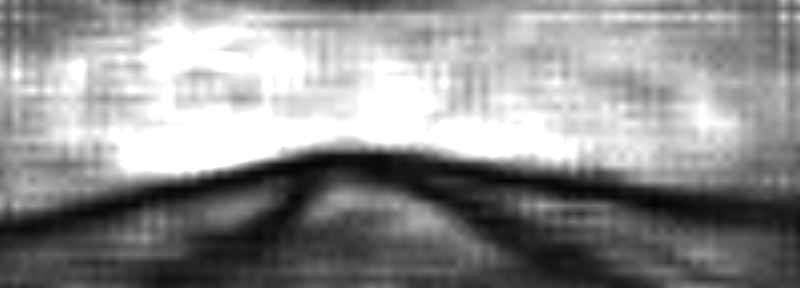

In [40]:
cv2_imshow(k3)

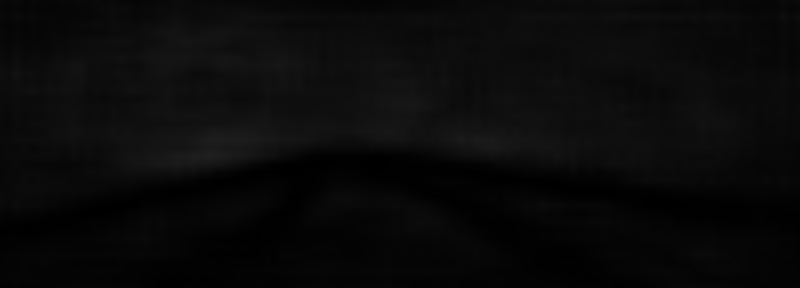

In [37]:
cv2_imshow(k1)

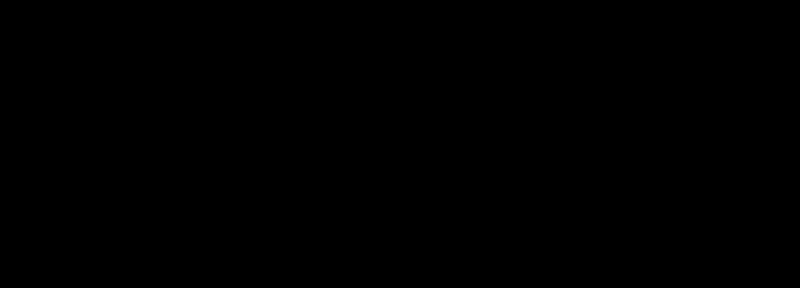

In [38]:
cv2_imshow(k2)

In [29]:
print(seg_l)

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])


In [ ]:
net.load_state_dict(torch.load(f'exp0_best.pt'))

RuntimeError: ignored

# 구조

In [ ]:
backbone = models.vgg16_bn(pretrained=True).features

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
conv = backbone._modules

In [ ]:
conv

OrderedDict([('0',
              Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
             ('1',
              BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
             ('2', ReLU(inplace=True)),
             ('3',
              Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
             ('4',
              BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
             ('5', ReLU(inplace=True)),
             ('6',
              MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
             ('7',
              Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
             ('8',
              BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
             ('9', ReLU(inplace=True)),
             ('10',
              Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
             ('11

In [ ]:
for i in [34, 37, 40]:
  conv = backbone._modules[str(i)]
  dilated_conv = nn.Conv2d(
      conv.in_channels, conv.out_channels, conv.kernel_size, stride=conv.stride,
      padding=tuple(p * 2 for p in conv.padding), dilation=2, bias=(conv.bias is not None)
            )
  dilated_conv.load_state_dict(conv.state_dict())
  backbone._modules[str(i)] = dilated_conv
backbone._modules.pop('33')
backbone._modules.pop('43')

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [ ]:
backbone._modules

OrderedDict([('0',
              Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
             ('1',
              BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
             ('2', ReLU(inplace=True)),
             ('3',
              Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
             ('4',
              BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
             ('5', ReLU(inplace=True)),
             ('6',
              MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
             ('7',
              Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
             ('8',
              BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
             ('9', ReLU(inplace=True)),
             ('10',
              Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
             ('11